In [65]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np
import project_utils.binary_classification as bc
importlib.reload(bc)

utils.default_plot_format()
utils.pd_display_settings(3)

In [66]:
#data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
data_path = r"processed_data\raw_metrics\comorbidities.pkl"

In [67]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
4115,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4116,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4117,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4118,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4119,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [68]:
median_melted = deciles.produce_median_melt(data, indicator_columns)
median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False]
              precision    recall  f1-score   support

       False       0.90      1.00      0.95        28
        True       1.00      0.25      0.40         4

    accuracy                           0.91        32
   macro avg       0.95      0.62      0.67        32
weighted avg       0.92      0.91      0.88        32

Accuracy: 0.90625


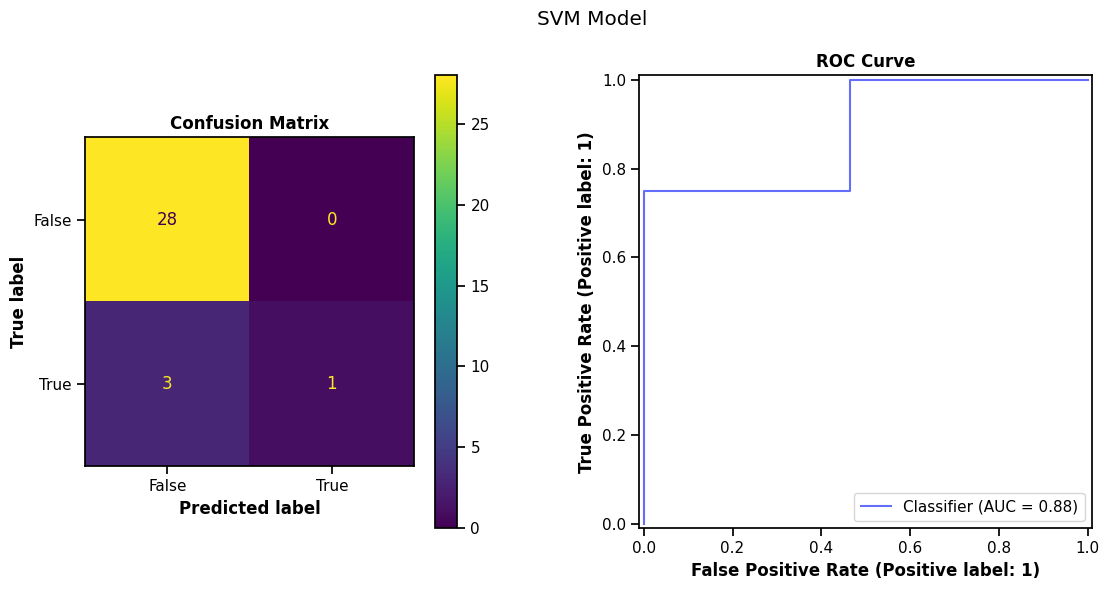

In [69]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
importlib.reload(bc)

def build_svm(data, columns = None, kernel='linear'):
    y = median_pivot["DPN"]
    X = data.drop(columns=["id", "DPN"])  # Features
    if columns:
        X = X[columns]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Build and train the SVM model
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_scaled, y)
    return svm_model, X_scaled, y


def plot_cvm_result(svm_model, X_scaled, y,  title="SVM Model"):
    
    y_pred = svm_model.predict(X_scaled)
    print("Predictions:", y_pred)
    print(classification_report(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    res = {
            'confusion_matrix': bc.confusion_matrix(y, y_pred),
            'y_pred_proba': svm_model.decision_function(X_scaled)
        }


    # Call the function to plot evaluation metrics
    bc.plot_evaluation_metrics(res, y, title=title)

plot_cvm_result(*build_svm(median_pivot))

In [70]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)

vif_median = median_pivot.copy()


def automatic_vif_reduction(data, keep_n=5):
    data=data.copy()
    removed_features = []
    for _ in range(len(data.columns) - 2 - keep_n):
        vif_data = LV.get_vif(data.drop(columns=['id', 'DPN']))
        max_vif_value = vif_data["Full VIF"].max()

        max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
        data = data.drop(columns=[max_vif_col])
        removed_features.append(max_vif_col)
    print(f"Removed: {removed_features}")
    return data, removed_features


def plot_vif_reduction(vif_median, removed_features):
    remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
    print(f"Remaining features: {remaining_features}")
    lda_df, lda = LV.perform_lda(vif_median, remaining_features)
    LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
    LV.show_linear_lda_stats(lda, remaining_features)
    LV.plot_vif(LV.get_vif(vif_median.drop(columns=['id', 'DPN'])))

#vif_median, removed_features = automatic_vif_reduction(median_pivot.copy())
#plot_vif_reduction(vif_median, removed_features)


Removed: ['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'SD2', 'DFA α2', 'SampEn', 'LF Power', 'SD1÷SD2']

 columns left: Index(['id', 'DPN', 'D2', 'HF Power', 'LF÷HF Ratio', 'S', 'VLF Power',
       'pNN50 (%)'],
      dtype='object', name='metric')
Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
              precision    recall  f1-score   support

       False       0.88      1.00      0.93        28
        True       0.00      0.00      0.00         4

    accuracy                           0.88        32
   macro avg       0.44      0.50      0.47        32
weighted avg       0.77      0.88      0.82        32

Accuracy: 0.875


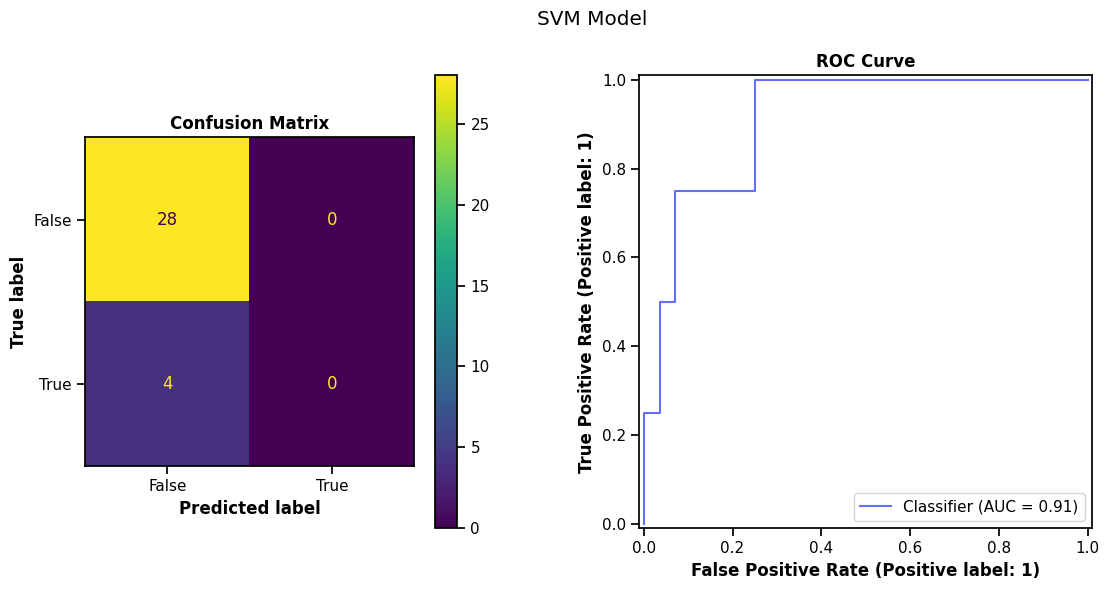

Remaining features: ['D2', 'HF Power', 'LF÷HF Ratio', 'S', 'VLF Power', 'pNN50 (%)']


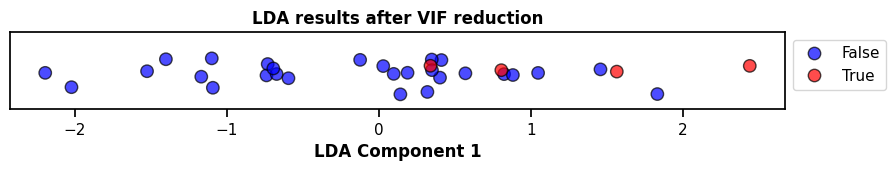

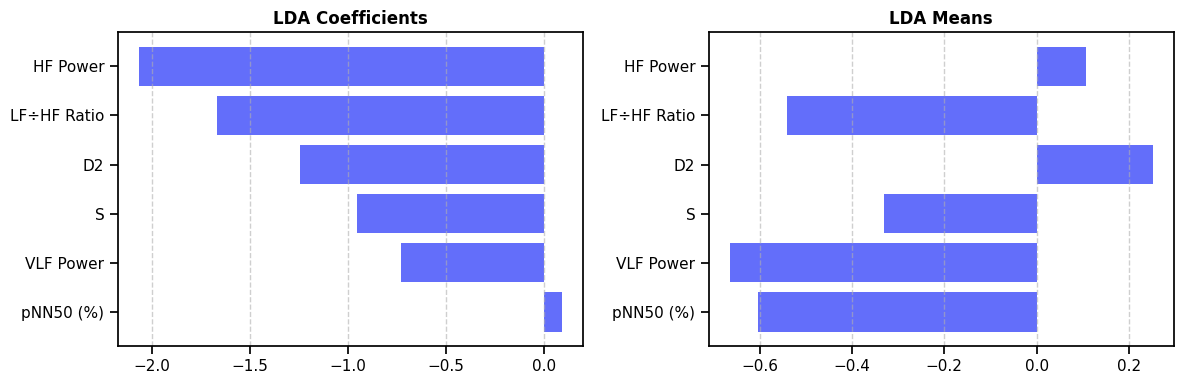

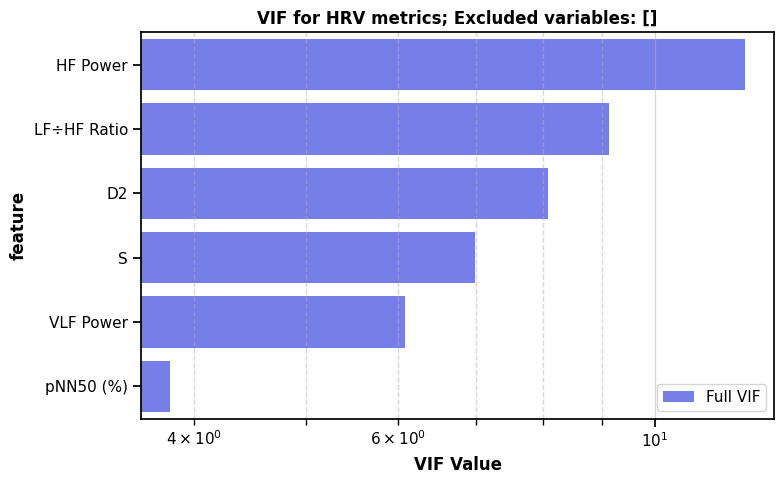

In [71]:

vif_median, removed_features = automatic_vif_reduction(median_pivot, 6)
print("\n columns left:",vif_median.columns)
plot_cvm_result(*build_svm(vif_median))
plot_vif_reduction(vif_median, removed_features)

## Recursive SVM feature reduction

In [72]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

In [73]:

#data = median_pivot.copy()
#y = data["DPN"]  # Target
#X = data.drop(columns=["id", "DPN"])  # Features

#estimator = SVR(kernel="linear")

#selector = RFECV(estimator, step=1, cv=5)
#selector = selector.fit(X, y)

Optimal number of features: 1
Selected features: Index(['ApEn'], dtype='object', name='metric')

# Linear SVM with feature selection

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import warnings
from sklearn.feature_selection import SequentialFeatureSelector

Selected 3 features: ['D2', 'DFA α1', 'DFA α2']
Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
              precision    recall  f1-score   support

       False       0.88      1.00      0.93        28
        True       0.00      0.00      0.00         4

    accuracy                           0.88        32
   macro avg       0.44      0.50      0.47        32
weighted avg       0.77      0.88      0.82        32

Accuracy: 0.875


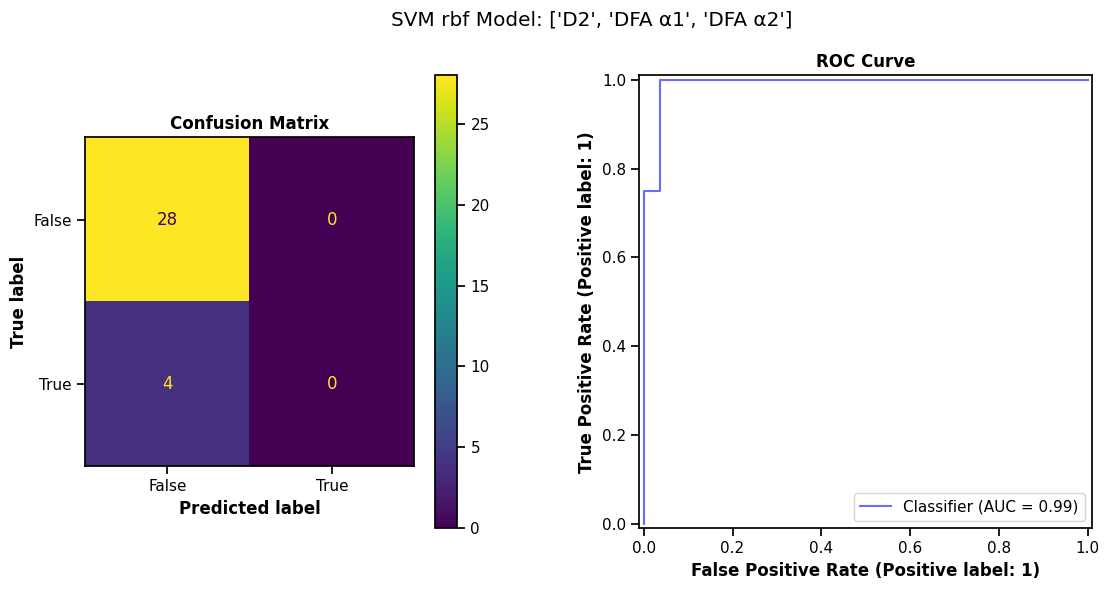

In [85]:


warnings.filterwarnings('ignore')
n= 3
data = median_pivot.copy()
data =data.drop(columns=['ApEn'])

y = data["DPN"]  # Target
X = data.drop(columns=["id", "DPN"])  # Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

estimator = SVC(kernel='rbf', random_state=42)
estimator.fit(X_scaled, y)

sfs = SequentialFeatureSelector(estimator, n_features_to_select=n, direction="forward", scoring='precision', cv=5)
sfs.fit(X_scaled, y)
selected_features = X.columns[sfs.get_support()].tolist()

print(f"Selected {len(selected_features)} features:", selected_features)

#Radial basis
plot_cvm_result(*build_svm(data, selected_features,'rbf'), title=f"SVM rbf Model: {selected_features}")

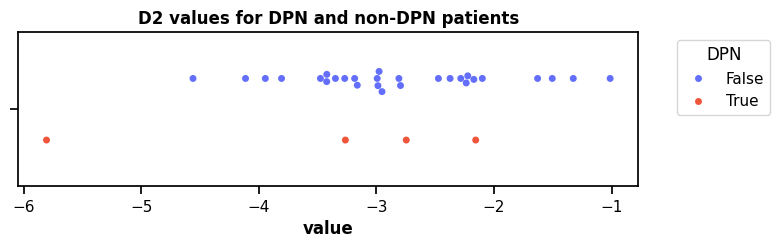

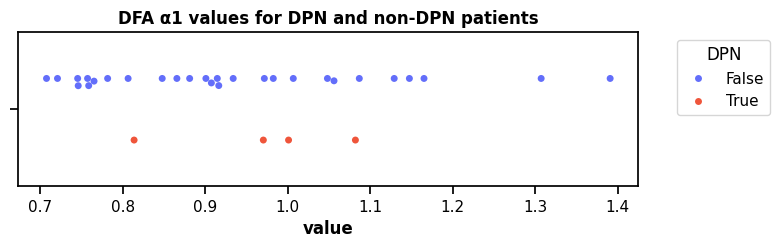

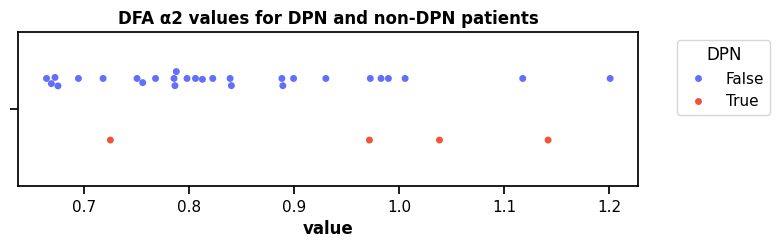

In [88]:
for feature in selected_features:
    plt.figure(figsize=(8, 2))
    sns.swarmplot(
        data=median_melted[median_melted['metric'] == feature],
        hue='DPN',
        x='value',
        dodge=True
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
    plt.title(f'{feature} values for DPN and non-DPN patients')
    plt.show()

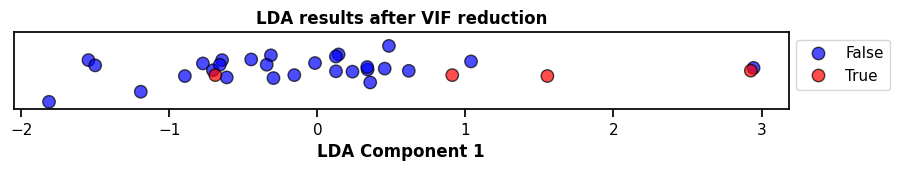

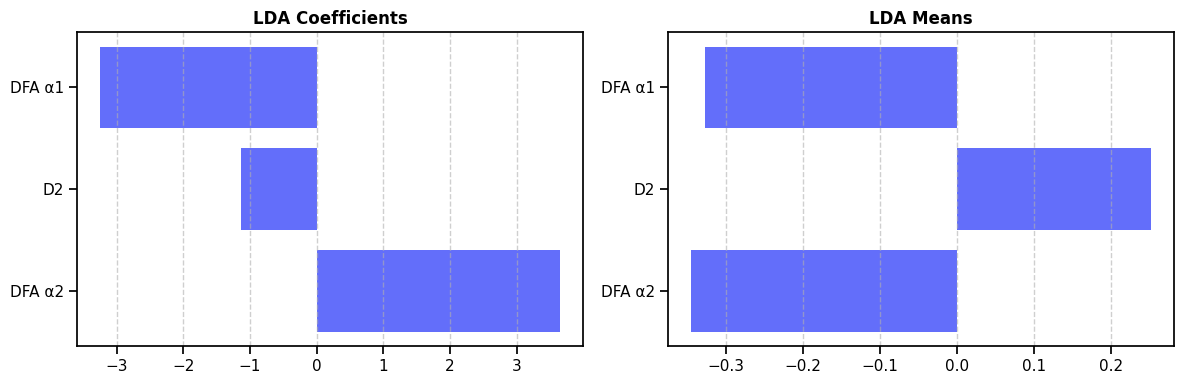

,Columns,LDA Coef,Means
0,D2,-1.14,0.25
1,DFA α1,-3.24,-0.33
2,DFA α2,3.65,-0.34


In [86]:

lda_df, lda = LV.perform_lda(median_pivot, selected_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, selected_features)

#